In [1]:
from config_submit1 import * #Set the configuration file name
conf = config()

In [2]:
import copy
import random

from IPython.display import clear_output
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import timm
from timm.scheduler import CosineLRScheduler
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torchinfo import summary
from torchlibrosa.augmentation import SpecAugmentation 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

import NeSsi.nessi as nessi
from pcgrad import PCGrad

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
root_path = "../TAU-urban-acoustic-scenes-2022-mobile-development/"
setup_path = root_path + "evaluation_setup/"

## checking csv data

In [5]:
train_csv = pd.read_table(setup_path + "fold1_train.csv")
val_csv = pd.read_table(setup_path + "fold1_evaluate.csv")
test_csv = pd.read_table(setup_path + "fold1_test.csv")

In [6]:
display(train_csv.head())
display(val_csv.head())
display(test_csv.head())

,filename,scene_label
0,audio/airport-lisbon-1000-40000-0-a.wav,airport
1,audio/airport-lisbon-1000-40000-1-a.wav,airport
2,audio/airport-lisbon-1000-40000-2-a.wav,airport
3,audio/airport-lisbon-1000-40000-3-a.wav,airport
4,audio/airport-lisbon-1000-40000-4-a.wav,airport


,filename,scene_label
0,audio/airport-barcelona-203-6129-0-a.wav,airport
1,audio/airport-barcelona-203-6129-1-a.wav,airport
2,audio/airport-barcelona-203-6129-2-a.wav,airport
3,audio/airport-barcelona-203-6129-3-a.wav,airport
4,audio/airport-barcelona-203-6129-4-a.wav,airport


,filename
0,audio/airport-barcelona-203-6129-0-a.wav
1,audio/airport-barcelona-203-6129-1-a.wav
2,audio/airport-barcelona-203-6129-2-a.wav
3,audio/airport-barcelona-203-6129-3-a.wav
4,audio/airport-barcelona-203-6129-4-a.wav


## Checking label

#### Training data

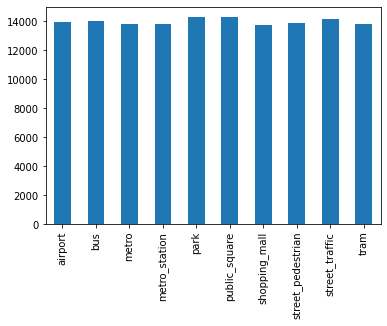

In [7]:
train_csv["scene_label"].value_counts(sort=False).plot.bar();

#### Validation data

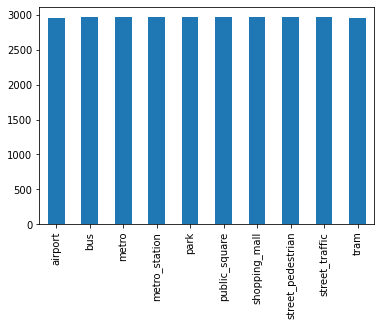

In [8]:
val_csv["scene_label"].value_counts(sort=False).plot.bar();

In [9]:
label_list = train_csv["scene_label"].unique()
print(label_list)

['airport' 'bus' 'metro' 'metro_station' 'park' 'public_square'
 'shopping_mall' 'street_pedestrian' 'street_traffic' 'tram']


In [10]:
devices = ([
        "a",
        "b",
        "c",
        "s1",
        "s2",
        "s3",
        "s4",
        "s5",
        "s6"
    ])
print(devices)

['a', 'b', 'c', 's1', 's2', 's3', 's4', 's5', 's6']


## Wav to MelSpectrogram

In [11]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=conf.sample_rate,
    n_fft=conf.n_fft,
    win_length=conf.win_length,
    hop_length=conf.hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=conf.n_mels,
    mel_scale="htk",
)

In [12]:

def wav_to_mel_log10(filepath):
    wave, _ = torchaudio.load(filepath)
    return torch.log10(mel_spectrogram(wave) + 1e-10)


def normalize_std(melspec):
    return (melspec-torch.mean(melspec, dim=(2,3), keepdim=True)) / torch.std(melspec, dim=(2,3), keepdim=True)


def label_to_onehot(scene_label, label_list):
    label_temp = torch.zeros(label_list.shape)
    label_temp[label_list==scene_label] = 1
    return label_temp


def get_devices_no(filename, devices):
    return devices.index(filename.split('-')[-1][:-4])


def label_for_multi(y):
    multi_y = np.zeros((y.shape[0],3))
    for i in range(y.shape[0]):
        if np.argmax(y[i,:])==0 or np.argmax(y[i,:])==3 or np.argmax(y[i,:])==6: #Indoor
            multi_y[i,0] = 1
        elif np.argmax(y[i,:])==4 or np.argmax(y[i,:])==5 or np.argmax(y[i,:])==7 or np.argmax(y[i,:])==8: #Outdoor
            multi_y[i,1] = 1
        else:
            multi_y[i,2] = 1 #Transportation
    return multi_y


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow((spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
    
def plot_confusion_matrix(true, predicted):
    cm = confusion_matrix(true, predicted, normalize="true")
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(cm, square=True, cbar=False, annot=True, cmap="Blues")
    ax.set_xticklabels(label_list, rotation=90) 
    ax.set_yticklabels(label_list, rotation=0) 
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
def plot_device_wise_log_losses(loss_all, predicted_all, train_val_y, train_val_devices, devices):
    results_table = np.zeros((11, len(devices)+2))

    for label_id, _ in enumerate(label_list):
        label_indx = (train_val_y[:,label_id]==1)
        results_table[label_id, len(devices)+1] = (predicted_all[label_indx]==label_id).sum()/label_indx.sum()*100
        results_table[label_id, 0] = loss_all[label_indx].mean()

        for device_id, _ in enumerate(devices):
            device_indx = np.array(train_val_devices)==device_id
            device_wise_indx = np.array(label_indx)*(device_indx)
            results_table[label_id, device_id + 1] = loss_all[device_wise_indx].mean()
            results_table[10, device_id+1] = loss_all[device_indx].mean()

    results_table[10, len(devices)+1] = (predicted_all == torch.argmax(train_val_y, dim=1).clone().numpy()).sum()/len(predicted_all)*100
    results_table[10, 0] = loss_all.mean()

    df_results = pd.DataFrame(results_table, columns=["Log Loss", *devices, "Accuracy %"], index=[ *label_list, "Ovberall"])    
    display(df_results)  

## preprosessing
#### training data

In [13]:
if conf.reuse:
    train_X = np.load(f"reuse/{conf.reusefolder}train_X.npy")
    train_X = torch.from_numpy(train_X.astype(np.float32)).clone()
    train_y = np.load(f"reuse/{conf.reusefolder}train_y.npy")
    train_y = torch.from_numpy(train_y.astype(np.float32)).clone()
    train_y_3class = np.load(f"reuse/{conf.reusefolder}train_y_3class.npy")
    train_y_3class = torch.from_numpy(train_y_3class.astype(np.float32)).clone()
    train_devices = np.load(f"reuse/{conf.reusefolder}train_devices.npy")
else:
    train_X = []
    train_y = []
    train_devices = []

    for filename, scene_label in zip(tqdm(train_csv['filename']), train_csv['scene_label']):
        train_X.append(wav_to_mel_log10(root_path + filename))
        
        train_y.append(label_to_onehot(scene_label, label_list))
        train_devices.append(get_devices_no(filename, devices))

    train_X = torch.stack(train_X)   
    train_y = torch.stack(train_y)  
    
    train_y_3class = label_for_multi(train_y)
    train_y_3class = torch.from_numpy(train_y_3class.astype(np.float32)).clone()
    
    np.save(f"reuse/{conf.reusefolder}train_X.npy", train_X)
    np.save(f"reuse/{conf.reusefolder}train_y.npy", train_y)
    np.save(f"reuse/{conf.reusefolder}train_y_3class.npy", train_y_3class)
    np.save(f"reuse/{conf.reusefolder}train_devices.npy", train_devices)

print(train_X.shape)

torch.Size([139620, 1, 256, 44])


#### Validation data

In [14]:
if conf.reuse:
    val_X = np.load(f"reuse/{conf.reusefolder}val_X.npy")
    val_X = torch.from_numpy(val_X.astype(np.float32)).clone()
    val_y = np.load(f"reuse/{conf.reusefolder}val_y.npy")
    val_y = torch.from_numpy(val_y.astype(np.float32)).clone()
    val_y_3class = np.load(f"reuse/{conf.reusefolder}val_y_3class.npy")
    val_y_3class = torch.from_numpy(val_y_3class.astype(np.float32)).clone()
    val_devices = np.load(f"reuse/{conf.reusefolder}val_devices.npy")
else:
    val_X = []
    val_y = []
    val_devices = []

    for filename, scene_label in zip(tqdm(val_csv["filename"]), val_csv["scene_label"]):
        mel_spec = wav_to_mel_log10(root_path + filename)
        val_X.append(mel_spec)
        val_y.append(label_to_onehot(scene_label, label_list))
        val_devices.append(get_devices_no(filename, devices))

    val_X = torch.stack(val_X)
    val_y = torch.stack(val_y)   

    val_y_3class = label_for_multi(val_y)
    val_y_3class = torch.from_numpy(val_y_3class.astype(np.float32)).clone()
    
    np.save(f"reuse/{conf.reusefolder}val_X.npy", val_X)
    np.save(f"reuse/{conf.reusefolder}val_y.npy", val_y)
    np.save(f"reuse/{conf.reusefolder}val_y_3class.npy", val_y_3class)
    np.save(f"reuse/{conf.reusefolder}val_devices.npy", val_devices)

In [15]:
if conf.include_val:
    train_X = torch.cat((train_X, val_X), 0)
    train_y = torch.cat((train_y, val_y), 0)
    train_y_3class = torch.cat((train_y_3class, val_y_3class), 0)
    train_devices = np.concatenate((train_devices, val_devices), 0)

val_X = normalize_std(val_X)

In [16]:
ComputeDeltas = torchaudio.transforms.ComputeDeltas(win_length= 5)
val_X2 = ComputeDeltas(val_X)
val_X2 = normalize_std(val_X2)
val_X = torch.cat((val_X,val_X2), 1)

In [17]:
# Create data loaders.
train_dataset = torch.utils.data.TensorDataset(train_X, train_y, train_y_3class)
val_dataset = torch.utils.data.TensorDataset(val_X, val_y, val_y_3class)
train_dataloader = DataLoader(train_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=conf.batch_size, shuffle=True, num_workers=2)

In [18]:
for X, y, y_3class in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 1, 256, 44])
Shape of y: torch.Size([16, 10]) torch.float32


In [19]:
del train_X, train_y

## Network

In [20]:
n_output = label_list.shape[0] + 3
n_hidden = 100

class DSConvLayer(nn.Module):
    def __init__(self, input, output):
        super(DSConvLayer, self).__init__()
        self.conv = nn.Conv2d(input, output, 1, stride=1, padding=0)
        self.DWconv16 = nn.Conv2d(input, output, 3, groups=output, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(input, eps=1e-03, momentum=0.01)
    def forward(self, x):
        x = self.bn(x) 
        x = self.relu(x)
        x = self.DWconv16(x)
        x = self.conv(x)
        return x
    
    
class DSConvLayer2(nn.Module):
    def __init__(self, input, output):
        super(DSConvLayer2, self).__init__()
        self.conv = nn.Conv2d(input, output, 1, stride=1, padding=0)
        self.DWconv16 = nn.Conv2d(input, output, 3, groups=output, stride=1, padding=1)

    def forward(self, x):
        x = self.DWconv16(x)
        x = self.conv(x)
        return x

    
class Model(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.quant = torch.quantization.QuantStub()

        self.conv1 = nn.Conv2d(2, 16, 5, stride=1, padding=2)
        self.conv2 = DSConvLayer2(16,16)
        self.conv3 = DSConvLayer(16,16)
        self.conv4 = DSConvLayer2(16,16)
        self.conv5 = DSConvLayer(16,16)
        self.conv6 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv7 = DSConvLayer(16,16)
        self.conv8 = DSConvLayer(16,16)
        self.conv9 = DSConvLayer(16,16)
        self.conv10 = DSConvLayer(16,16)

        self.bn = nn.BatchNorm2d(16, eps=1e-03, momentum=0.01)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.maxpool1 = nn.MaxPool2d((3,2))
        self.maxpool2 = nn.MaxPool2d((6,4))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(1120, n_hidden) 
        self.l2 = nn.Linear(n_hidden, n_output)
        self.shortcut = nn.quantized.FloatFunctional()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        out = self.relu(self.bn(self.conv1(x)))

        x1 = self.conv2(out[:,:,:124,:])
        x1 = self.conv3(x1)
        x2 = self.conv4(out[:,:,124:,:])
        x2 = self.conv5(x2)
        x = torch.cat((x1, x2), dim=2)
        x = self.dropout(self.maxpool1(x))

        out = self.conv6(x)
        x = self.conv7(out)
        x = self.conv8(x)
        out = self.shortcut.add(x, out)

        x = self.conv9(out)
        x = self.conv10(x)
        x = self.shortcut.add(x, out)
        
        x = self.dropout(self.maxpool2(x))
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.l2(x)
        x = self.dequant(x)
        return x

model = Model(n_output, n_hidden)
model.qconfig = torch.quantization.get_default_qat_qconfig("qnnpack")

In [21]:
nessi.get_model_size(model, "torch", input_size = (1,2,X.shape[2],X.shape[3]))

Model statistics:
MACC:	 	 26.607 M
Params:	 	 120.229 K



In [22]:
summary(model, input_size=(1, 2, X.shape[2], X.shape[3]), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─QuantStub: 1-1                         [1, 2, 256, 44]           --
├─Conv2d: 1-2                            [1, 16, 256, 44]          816
├─BatchNorm2d: 1-3                       [1, 16, 256, 44]          32
├─ReLU: 1-4                              [1, 16, 256, 44]          --
├─DSConvLayer2: 1-5                      [1, 16, 124, 44]          --
│    └─Conv2d: 2-1                       [1, 16, 124, 44]          160
│    └─Conv2d: 2-2                       [1, 16, 124, 44]          272
├─DSConvLayer: 1-6                       [1, 16, 124, 44]          --
│    └─BatchNorm2d: 2-3                  [1, 16, 124, 44]          32
│    └─ReLU: 2-4                         [1, 16, 124, 44]          --
│    └─Conv2d: 2-5                       [1, 16, 124, 44]          160
│    └─Conv2d: 2-6                       [1, 16, 124, 44]          272
├─DSConvLa

In [23]:
model.train()
model = torch.quantization.prepare_qat(model).to(device)

In [24]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=100, lr_min=1e-6, warmup_t=5, warmup_lr_init=5e-5, warmup_prefix=True)
optimizer = PCGrad(optimizer)

# Augmentation

In [25]:
def core_mixup(X, y, ym, alpha=0.2, beta=0.2):

    indices = torch.randperm(X.size(0)) 
    X2 = X[indices,:,:,:]
    y2 = y[indices,:]
    ym2 = ym[indices,:]

    lam = torch.FloatTensor([np.random.beta(alpha, beta)])  # β分布を左右非対称にもできるようにした

    X = lam*X + (1-lam)*X2  
    y = lam*y + (1-lam)*y2
    ym = lam*ym + (1-lam)*ym2
    
    return  X, y, ym


def mixup(X, y, ym, epoch):
    
    if epoch < 60:
        X, y, ym = core_mixup(X, y, ym)            
    else:
        X[:len(X)//2,:,:,:], y[:len(y)//2,:], ym[:len(ym)//2,:] = core_mixup(X[:len(X)//2,:,:,:], y[:len(y)//2,:], ym[:len(ym)//2,:])
            
    return X, y, ym

#SpecAugment
spec_augmenter = SpecAugmentation(
            time_drop_width=2,
            time_stripes_num=2,
            freq_drop_width=2,
            freq_stripes_num=2)

,filename,device_name,dif_freq
0,audio/airport-lisbon-1000-40000-0-s3.wav,s3,"[-2.9059536, -3.1832728, -3.2194438, -3.210605..."
1,audio/airport-lisbon-1000-40000-1-s3.wav,s3,"[-2.7815063, -2.9213529, -3.0552177, -3.053175..."
2,audio/airport-lisbon-1000-40000-2-s3.wav,s3,"[-2.8971777, -3.1116288, -3.3094707, -3.202556..."
3,audio/airport-lisbon-1000-40000-3-s3.wav,s3,"[-3.0583305, -3.0710726, -3.0896604, -3.183244..."
4,audio/airport-lisbon-1000-40000-4-s3.wav,s3,"[-2.6388025, -2.9723158, -3.1361861, -3.123651..."


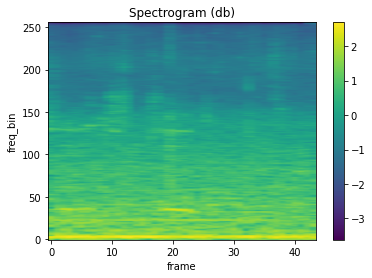

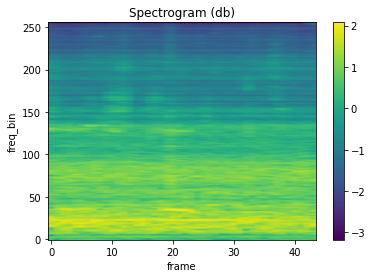

tensor([0., 1., 0.])
Shape of X [N, C, H, W]: torch.Size([16, 1, 256, 44])
Shape of y: torch.Size([16, 10]) torch.float32


In [26]:
if conf.DIFF_FREQ:
    diff_freq_list = pd.read_pickle(f"reuse/{conf.reusefolder}diff_freq.pkl") 
    if conf.include_val:
        diff_freq_list_val = pd.read_pickle(f"reuse/{conf.reusefolder}diff_freq_val.pkl") 
        diff_freq_list = pd.concat([diff_freq_list, diff_freq_list_val])
    display(diff_freq_list.head())

    dif_devices_train_list = [
            "b",
            "c",
            "s1",
            "s2",
            "s3",
        ]

    diff_freq_power = torch.from_numpy(np.stack(diff_freq_list["dif_freq"].values).astype(np.float32)).clone()
    
def apply_diff_freq(X, diff_freq_power, devices_no):
    if random.randrange(0, 13, 1) != 0: # 1/13skip
        for idx, (X_temp, device_no) in enumerate(zip(X, devices_no)):
            tmp = (device_no==0)*diff_freq_power[random.randrange(0, len(diff_freq_power), 1),:].unsqueeze(0).unsqueeze(2)
            tmp = torch.from_numpy(np.dot(torch.ones((X.shape[3],1)), tmp[:,:,0])).clone()
            X[idx,0,:,:] = X_temp[0,:,:] + tmp.T

    return X

#Check the effect
for X, y, devices_no in train_dataloader:
    X, y = X.to("cpu"), y.to("cpu")
    X_ori = normalize_std(X)
    plot_spectrogram(X_ori[0,0,:,:])
    X = apply_diff_freq(X, diff_freq_power, devices_no)
    X = normalize_std(X)
    plot_spectrogram((X[0,0,:,:]))
    print(devices_no[0])
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

## Train loop

In [27]:
def train(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    train_loss = 0
    n_train = 0
    correct = 0
    model.train()

    for batch, (X, y, y_3class) in enumerate(dataloader):
        
        if conf.MIXUP:
            X, y, y_3class = mixup(X, y, y_3class, t)
        if conf.DIFF_FREQ:
            X = apply_diff_freq(X, diff_freq_power, devices_no)
            
        X = normalize_std(X)  
        X2 = ComputeDeltas(X)
        X2 = normalize_std(X2)   
        X = torch.cat((X,X2),1)
        
        if conf.SPEC_AUG:
            X = spec_augmenter(X)
        X, y, y_3class = X.to(device), y.to(device), y_3class.to(device)

        # Compute prediction error
        pred = model(X)
        loss, loss_3class = loss_fn(pred[:,:-3], y), loss_fn(pred[:,-3:], y_3class)

        # Backpropagation
        optimizer.zero_grad()
        optimizer.pc_backward([loss, loss_3class]) 
        optimizer.step()
        scheduler.step(t+1)
        train_loss += loss.item()
        
        _, predicted = torch.max(pred[:,:-3].detach(), 1)
        _, y_predicted = torch.max(y.detach(), 1)
        correct += (predicted == y_predicted).sum().item()
        
        n_train += len(X)
        if batch % 500 == 0:
            loss_current, acc_current, current = train_loss/n_train, correct/n_train, batch * len(X)
            print(f"Train Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
    
    loss_current, acc_current = train_loss/n_train, correct/n_train   
    return loss_current, acc_current

In [28]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss = 0
    n_val = 0
    correct = 0
    model.eval()
    with torch.no_grad():        
        for batch, (X, y, y_3class) in enumerate(dataloader):

            X, y, y_3class = X.to(device), y.to(device), y_3class.to(device)
            
            pred = model(X)
            loss, loss_3class = loss_fn(pred[:,:-3], y), loss_fn(pred[:,-3:], y_3class)

            val_loss += loss.item()
            
            _, predicted = torch.max(pred[:,:-3].detach(), 1)
            _, y_predicted = torch.max(y.detach(), 1)
            correct += (predicted == y_predicted).sum().item()
            
            n_val += len(X)
            if batch % 500 == 0:
                loss_current, acc_current, current = val_loss/n_val, correct/n_val, batch*len(X)
                print(f"Val Epoch: {t+1} loss: {loss_current:>7f}  accuracy: {acc_current:>7f} [{current:>5d}/{size:>5d}]")
                
    loss_current, acc_current = val_loss/n_val, correct/n_val
    return loss_current, acc_current

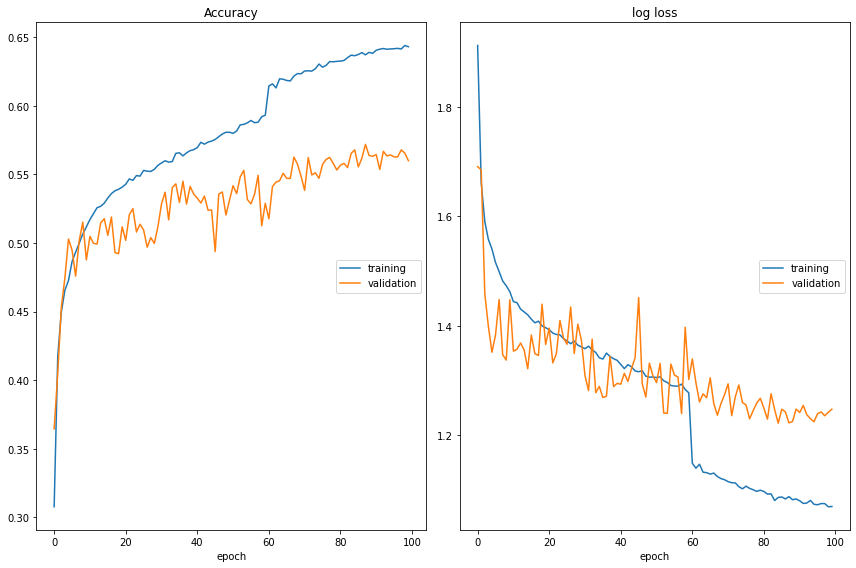

Accuracy
	training         	 (min:    0.308, max:    0.644, cur:    0.643)
	validation       	 (min:    0.365, max:    0.572, cur:    0.560)
log loss
	training         	 (min:    1.070, max:    1.912, cur:    1.070)
	validation       	 (min:    1.222, max:    1.691, cur:    1.248)


In [29]:
liveloss = PlotLosses()
min_loss = 5
for t in range(conf.epochs):
    logs = {}
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer, t)
    val_loss, val_acc = val(val_dataloader, model, loss_fn)
    logs["log loss"] = train_loss
    logs["val_log loss"] = val_loss
    logs["acc"] = train_acc
    logs["val_acc"] = val_acc
    liveloss.update(logs)
    liveloss.send()
    
    if min_loss > val_loss:
        min_loss = val_loss
        torch.save(copy.deepcopy(model).state_dict(), "model/model_min.pt")

torch.save(copy.deepcopy(model).state_dict(), "model/model.pt")

In [30]:
# loading model
model.load_state_dict(torch.load("model/model_min.pt"))
model = model.to("cpu")

In [31]:
model_int8 = torch.quantization.convert(model)

## Results

In [32]:
batch_size = 1
val_result_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
loss_fn_inference = nn.CrossEntropyLoss(reduction="none")

In [33]:
def inference(dataloader, model, loss_fn, device):
    loss_all = []
    predicted_all = []
    predicted_all_3class = []

    model.eval()
    with torch.no_grad():        
        for batch, (X, y, y_3class) in enumerate(dataloader):
            X, y, y_3class = X.to(device), y.to(device), y_3class.to(device)

            pred = model(X)
            pred_multi = multi_for_label(pred[:,-3:]) #3class to 10class
            pred[:,:-3] = (pred[:,:-3]*conf.mix_rate + pred_multi*(1-conf.mix_rate))
            loss = loss_fn(pred[:,:-3], y)

            _, predicted = torch.max(pred[:,:-3].detach(), 1)
            _, predicted_3class = torch.max(pred[:,-3:].detach(), 1)
            
            loss_all.append(loss)
            predicted_all.append(predicted)
            predicted_all_3class.append(predicted_3class)

    return torch.flatten(torch.stack(loss_all)).numpy(), torch.flatten(torch.stack(predicted_all)).numpy(), torch.flatten(torch.stack(predicted_all_3class)).numpy()


def multi_for_label(y):
    multi_y = np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        multi_y[i,0] = y[i,0] #Indoor 
        multi_y[i,3] = y[i,0] #Indoor
        multi_y[i,6] = y[i,0] #Indoor
        multi_y[i,4] = y[i,1] #Outdoor
        multi_y[i,5] = y[i,1] #Outdoor
        multi_y[i,7] = y[i,1] #Outdoor
        multi_y[i,8] = y[i,1] #Outdoor
        multi_y[i,1] = y[i,2] #Trans
        multi_y[i,2] = y[i,2] #Trans
        multi_y[i,9] = y[i,2] #Trans
    return multi_y

In [34]:
loss_all, predicted_all, predicted_all_3class = inference(val_result_dataloader, model_int8, loss_fn_inference, "cpu")

In [35]:
val_y_3class_arg = torch.argmax(val_y_3class,1)
correct = 0
for i in range(len(val_y_3class_arg)):
    if predicted_all_3class[i] == val_y_3class_arg[i]:
        correct += 1
acc_3class = correct / len(val_y_3class_arg)
print(acc_3class) #accracy of 3class

0.8236859838274933


,Log Loss,a,b,c,s1,s2,s3,s4,s5,s6,Accuracy %
airport,1.324619,0.970355,1.253229,1.069484,1.332220,1.343202,1.282956,1.679348,1.648955,1.339660,45.709461
bus,0.849695,0.320410,1.208493,0.678004,0.933153,0.727905,0.706367,1.081221,1.063730,0.927972,71.515152
metro,1.305596,0.999226,1.372377,1.197043,1.442002,1.340383,1.247298,1.202679,1.610143,1.339212,49.090908
metro_station,1.320014,1.241433,1.513937,1.667856,1.362857,1.229750,1.169457,1.472500,1.233639,0.988695,51.986526
park,0.544018,0.377913,0.278481,0.404143,0.616953,0.581815,0.516898,0.649908,0.632341,0.837706,83.232323
public_square,1.597654,1.214541,1.873027,1.309855,1.407488,1.426535,1.391706,1.560295,1.749421,2.446012,43.973061
shopping_mall,1.019351,0.879755,0.838999,1.080366,0.944386,0.837632,1.030429,1.373014,0.993871,1.195711,64.713799
street_pedestrian,2.043329,1.760080,2.032274,1.967679,1.841905,1.785488,1.831103,2.302661,2.332065,2.536702,28.888887
street_traffic,0.626193,0.488266,0.730032,0.681506,0.606262,0.563792,0.658297,0.491804,0.412107,1.003673,77.373734
tram,1.320484,0.955783,1.311266,1.180768,1.055040,1.346157,1.022433,1.752630,1.547811,1.708231,55.675678


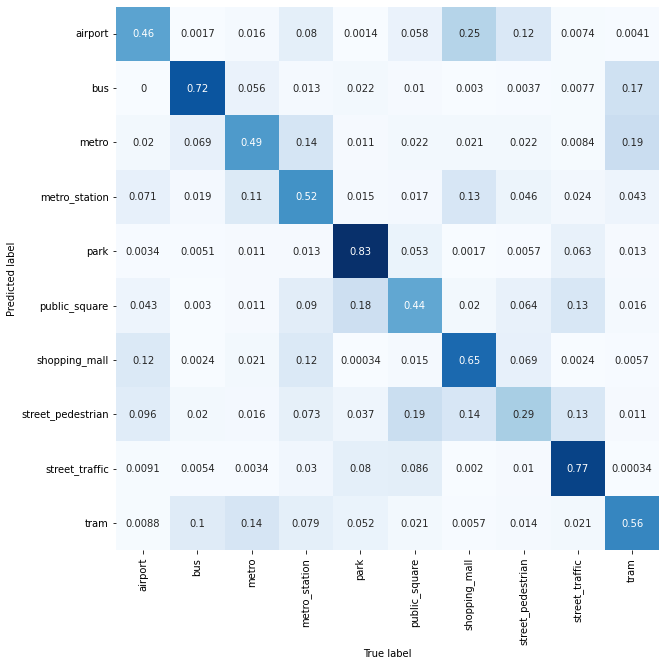

In [36]:
plot_device_wise_log_losses(loss_all, predicted_all, val_y, val_devices, devices)
plot_confusion_matrix(torch.argmax(val_y.detach(), 1), predicted_all)